In [37]:
%load_ext autoreload
%autoreload 2

import argparse
import yaml
import os, sys
import time
import logging, logging.config

import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterstats import zonal_stats
from shapely.geometry import mapping
from scipy.stats import kstest

import numpy as np
import stat
import math
import matplotlib

import matplotlib.pyplot as plt

from tqdm import tqdm

import fct_misc
%aimport fct_statistics

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
with open('config.yaml') as fp:
    cfg = yaml.load(fp, Loader=yaml.FullLoader)['statistical_analysis.py']    #  [os.path.basename(__file__)]


# Defitions of the functions


# Definition of the constants
DEBUG_MODE=cfg['debug_mode']
CORRECT_BALANCE=cfg['correct_balance']

BANDS=range(1,5)
MAX_CONFIDANCE_INT=cfg['param']['max_confidance']
COUNT_THRESHOLD = cfg['param']['pixel_threshold']

PROCESSED=cfg['processed']
PROCESSED_FOLDER=PROCESSED['processed_folder']
FINAL_FOLDER=cfg['final_folder']

## Inputs
ROADS=PROCESSED_FOLDER + PROCESSED['input_files']['roads']
TILES_DIR=PROCESSED_FOLDER + PROCESSED['input_files']['images']
TILES_INFO=PROCESSED_FOLDER + PROCESSED['input_files']['tiles']

written_files=[]
dirpath_f_tables=fct_misc.ensure_dir_exists(os.path.join(FINAL_FOLDER, 'tables'))
dirpath_f_images=fct_misc.ensure_dir_exists(os.path.join(FINAL_FOLDER, 'images'))


## Definition of functions

In [39]:
def im_of_hist_comp(band, roads, pixels_per_band, dirpath_f_images, prefix=''):
    '''
    Produce the comparison between the histogram of the pixels belonging to the road and all the pixels in its type of road cover.
    Save an image

    - band: band on which we are working
    - roads: roads of interest as a dataframe
    - pixels_per_band: dataframe with all the pixels
    - dirpath_f_images: path of the directory to save the image
    '''
    written_files_fct=[]

    for road_idx in roads.index:
        objectid=roads.loc[road_idx, 'road_id']
        cover=roads.loc[road_idx, 'road_type']
        p_value=roads.loc[road_idx, f'ks_p_{band}']

        road_pixels=pixels_per_band.loc[pixels_per_band['road_id'] == objectid, band]
        all_pixels=pixels_per_band.loc[pixels_per_band['road_type'] == cover, band]

        nbr_road_pixels=road_pixels.shape[0]

        ks_graph=fs.compare_histograms(road_pixels, all_pixels,
                                    label1='pixels of the road', label2=f'{cover} pixels',
                                    graph_title=f'''Histogram of the distribution of the {nbr_road_pixels} pixels
                                            on the {band} band (p-value: {p_value})''',
                                    axis_label='density of the pixels')

        ks_graph.savefig(os.path.join(dirpath_f_images, f'Hist_{prefix}{cover}_road_{int(objectid)}_band_{band}.jpeg'), bbox_inches='tight')

        written_files_fct.append(f'final/images/Hist_{prefix}{cover}_road_{objectid}_band_{band}.jpeg')

    plt.close('all')

    return written_files_fct

# Main

## Import data

In [40]:
# Importation of the files
roads=gpd.read_file(ROADS)
tiles_info = gpd.read_file(TILES_INFO)

In [43]:
print(roads.columns)
print(tiles_info.columns)
roads.shape[0]


Index(['OBJECTID', 'DATUM_AEND', 'DATUM_ERST', 'ERSTELLUNG', 'ERSTELLU_1',
       'REVISION_J', 'REVISION_M', 'GRUND_AEND', 'HERKUNFT', 'HERKUNFT_J',
       'HERKUNFT_M', 'REVISION_Q', 'OBJEKTART', 'KUNSTBAUTE', 'WANDERWEGE',
       'VERKEHRSBE', 'BEFAHRBARK', 'EROEFFNUNG', 'STUFE', 'RICHTUNGSG',
       'BELAGSART', 'KREISEL', 'EIGENTUEME', 'VERKEHRS_1', 'NAME',
       'TLM_STRASS', 'STRASSENNA', 'SHAPE_Leng', 'road_width', 'geometry'],
      dtype='object')
Index(['title', 'id_aoi', 'id', 'geometry'], dtype='object')


5019

## Data treatment

In [41]:
if DEBUG_MODE:
    tiles_info=tiles_info[1:500]

In [44]:
if True:
    unsure_roads=gpd.read_file(os.path.join(PROCESSED_FOLDER, 'shapefiles_gpkg/test_natural_roads.shp'))
    id_unsure_roads=unsure_roads['OBJECTID'].values.tolist()

    roads=roads[~roads['OBJECTID'].isin(id_unsure_roads)]

    print(roads.shape[0])


4996


In [7]:
if roads[roads.is_valid==False].shape[0]!=0:
       print(f"There are {roads[roads.is_valid==False].shape[0]} invalid geometries for the roads.")
       sys.exit(1)          

simplified_roads=roads.drop(columns=['ERSTELLUNG', 'ERSTELLU_1', 'HERKUNFT', 'HERKUNFT_J', 'HERKUNFT_M','KUNSTBAUTE', 'WANDERWEGE',
              'VERKEHRSBE', 'BEFAHRBARK', 'EROEFFNUNG', 'STUFE', 'RICHTUNGSG', 'KREISEL', 'EIGENTUEME', 'VERKEHRS_1', 'NAME',
              'TLM_STRASS', 'STRASSENNA', 'SHAPE_Leng'])


# to_file(PROCESSED_FOLDER + '/shapefiles_gpkg/test_invalid_geom.shp')

In [8]:
roads_reproj=simplified_roads.to_crs(epsg=3857)
tiles_info_reproj=tiles_info.to_crs(epsg=3857)

fp_list=[]
for tile_idx in tiles_info_reproj.index:
        # Get the name of the tiles
        x, y, z = tiles_info_reproj.loc[tile_idx,'id'].lstrip('(,)').rstrip('(,)').split(',')
        im_name = z.lstrip() + '_' + x + '_' + y.lstrip() + '.tif'
        im_path = os.path.join(TILES_DIR, im_name)
        fp_list.append(im_path)

tiles_info_reproj['filepath']=fp_list

fct_misc.test_crs(roads_reproj.crs, tiles_info_reproj.crs)


In [9]:
if roads_reproj[roads_reproj.is_valid==False].shape[0]!=0:
       print(f"There are {roads_reproj[roads_reproj.is_valid==False].shape[0]} invalid geometries for the road after the reprojection.")

       print("Correction of the roads presenting an invalid geometry with a buffer of 0 m...")
       corrected_roads=roads_reproj.copy()
       corrected_roads.loc[corrected_roads.is_valid==False,'geometry']=corrected_roads[corrected_roads.is_valid==False]['geometry'].buffer(0)


There are 84 invalid geometries for the road after the reprojection.
Correction of the roads presenting an invalid geometry with a buffer of 0 m...


In [10]:
clipped_roads=gpd.GeoDataFrame()
for idx in tqdm(tiles_info_reproj.index, desc='Clipping roads'):

    roads_to_tile = gpd.clip(corrected_roads, tiles_info_reproj.loc[idx,'geometry']).explode(index_parts=False)
    roads_to_tile['tile']=tiles_info_reproj.loc[idx, 'title']

    clipped_roads=pd.concat([clipped_roads, roads_to_tile], ignore_index=True)


Clipping roads: 100%|██████████| 499/499 [00:04<00:00, 111.00it/s]


In [11]:
print(corrected_roads.shape)
print(clipped_roads.shape)
print(tiles_info_reproj.head(5))


(5019, 11)
(1486, 12)
                                   title  id_aoi                id  \
1  XYZ tile Tile(x=68340, y=46156, z=17)      14  68340, 46156, 17   
2  XYZ tile Tile(x=68340, y=46157, z=17)      14  68340, 46157, 17   
3  XYZ tile Tile(x=68339, y=46158, z=17)       2  68339, 46158, 17   
4  XYZ tile Tile(x=68339, y=46165, z=17)       2  68339, 46165, 17   
5  XYZ tile Tile(x=68339, y=46177, z=17)       2  68339, 46177, 17   

                                            geometry  \
1  POLYGON ((857317.709 5925092.685, 857317.709 5...   
2  POLYGON ((857317.709 5924786.936, 857317.709 5...   
3  POLYGON ((857011.961 5924481.188, 857011.961 5...   
4  POLYGON ((857011.961 5922340.952, 857011.961 5...   
5  POLYGON ((857011.961 5918671.974, 857011.961 5...   

                                            filepath  
1  /mnt/data-01/gsalamin/proj-roadsurf-b/02_Data/...  
2  /mnt/data-01/gsalamin/proj-roadsurf-b/02_Data/...  
3  /mnt/data-01/gsalamin/proj-roadsurf-b/02_Data/...  


In [ ]:
# dirpath=fct_misc.ensure_dir_exists(os.path.join(PROCESSED_FOLDER, 'shapefiles_gpkg'))

# clipped_roads.to_file(os.path.join(dirpath, 'test_clipped_geom.shp')

### Calcul des statistiques de zone pour les routes

1. Avec rasterstats.zonal_stats

Test

In [ ]:
roads_on_tile=clipped_roads[clipped_roads['tile']==tiles_info_reproj.loc[1,'title']]

x, y, z = tiles_info_reproj.loc[1,'id'].lstrip('(,)').rstrip('(,)').split(',')
im_name = z.lstrip() + '_' + x + '_' + y.lstrip() + '.tif'
im_path = os.path.join(TILES_DIR, im_name)

test=zonal_stats(roads_on_tile.iloc[0:1], im_path, stats=['min', 'max', 'mean', 'median','std','count'], band=2)

In [ ]:
test

Implementation

In [ ]:
roads_stats=pd.DataFrame()

for tile_idx in tqdm(tiles_info_reproj.index, desc='Calculating zonal statistics'):

    roads_on_tile=clipped_roads[clipped_roads['tile']==tiles_info_reproj.loc[tile_idx,'title']]

    # Get the path of the tiles
    im_path=tiles_info_reproj.loc[tile_idx,'filepath']

    roads_on_tile.reset_index(drop=True, inplace=True)

    # Calculation for each road on each band
    for road_idx in roads_on_tile.index:

        road=roads_on_tile.iloc[road_idx:road_idx+1]

        if road.shape[0]>1:
            print('More than one road is being tested.')
            sys.exit(1)

        for band_num in BANDS:

            stats=zonal_stats(road, im_path, stats=['min', 'max', 'mean', 'median','std','count'], band=band_num, nodata=0)
            stats_dict=stats[0]
            stats_dict['band']=band_num
            stats_dict['road_id']=road.loc[road_idx,'OBJECTID']
            stats_dict['road_type']=road.loc[road_idx,'BELAGSART']
            stats_dict['geometry']=road.loc[road_idx,'geometry']
            stats_dict['tile_id']=tiles_info_reproj.loc[tile_idx,'id']

            roads_stats = pd.concat([roads_stats, pd.DataFrame(stats_dict,index=[0])],ignore_index=True)

roads_stats['mean']=roads_stats['mean'].round(1)
roads_stats['std']=roads_stats['std'].round(1)


In [ ]:
roads_stats[roads_stats['road_type']==200]


2. Avec les statistiques des pixels

In [12]:
# pixel_values=pd.DataFrame()
from shapely.geometry.multipolygon import MultiPolygon

roads_stats={'band':[], 'road_id': [], 'road_type': [], 'geometry': [],
            'min':[], 'max':[], 'mean':[], 'median':[], 'std':[], 'count':[], 'confidance': []}

for road_idx in tqdm(corrected_roads.index, desc='Extracting road statistics'):

    # Get the characteristics of the road
    objectid=corrected_roads.loc[road_idx, 'OBJECTID']
    cover_type=corrected_roads.loc[road_idx, 'BELAGSART']
    road=corrected_roads.loc[corrected_roads['OBJECTID'] == objectid,['OBJECTID', 'BELAGSART', 'geometry']]
    road.reset_index(inplace=True, drop=True)
    geometry = road.loc[0,'geometry'] if road.shape[0]==1 else MultiPolygon([road.loc[k,'geometry'] for k in road.index])

    if objectid in roads_stats['road_id']:
        continue
    
    # Get the corresponding tile(s)
    fct_misc.test_crs(road.crs, tiles_info_reproj.crs)
    intersected_tiles=gpd.overlay(tiles_info_reproj, road)

    intersected_tiles.drop_duplicates(subset=['id'], inplace=True)
    intersected_tiles.reset_index(drop=True, inplace=True)

    pixel_values=pd.DataFrame()

    # Get the pixels for each tile
    for tile_idx in intersected_tiles.index:

        # Get the name of the tiles
        im_path = intersected_tiles.loc[tile_idx,'filepath']
        
        pixel_values, no_data = fct_misc.get_pixel_values(road, im_path, BANDS, pixel_values,
                                                    road_id=objectid, road_cover=cover_type)

    if pixel_values.empty:
        continue

    for band in BANDS:
        pixels_subset=pixel_values[pixel_values['band_num']==band]

        roads_stats['band'].append(band)
        roads_stats['road_id'].append(objectid)
        roads_stats['road_type'].append(cover_type)
        roads_stats['geometry'].append(geometry)

        roads_stats=fct_statistics.get_df_stats(pixels_subset, 'pix_val', roads_stats)

roads_stats['max']=[int(x) for x in roads_stats['max']]
roads_stats['min']=[int(x) for x in roads_stats['min']]

roads_stats=pd.DataFrame(roads_stats)

Extracting road statistics: 100%|██████████| 5019/5019 [01:06<00:00, 75.59it/s] 
/home/gsalamin/Python_env/road_surfaces/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:1983: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values


In [14]:
roads_stats['mean']=roads_stats['mean'].round(1)
roads_stats['std']=roads_stats['std'].round(1)
roads_stats['confidance']=roads_stats['confidance'].round(2)

In [ ]:
print(roads_stats.shape[0]/4)

Finish

In [15]:
roads_stats_gdf=gpd.GeoDataFrame(roads_stats)

dirpath=fct_misc.ensure_dir_exists(os.path.join(PROCESSED_FOLDER, 'shapefiles_gpkg'))

# roads_stats_gdf.to_file(os.path.join(dirpath, 'roads_stats.shp'))
# written_files.append('processed/shapefiles_gpkg/roads_stats.shp')

In [16]:
roads_stats_df= roads_stats.drop(columns=['geometry'])

print(roads_stats_df.tail(8))

dirpath=fct_misc.ensure_dir_exists(os.path.join(PROCESSED_FOLDER,'tables'))


roads_stats_df.to_csv(os.path.join(dirpath, 'stats_roads.csv'), index=False)
written_files.append('processed/tables/road_stats.csv')

      band  road_id  road_type  min  max   mean  median   std  count  \
3480     1  30797.0        100  152  160  156.7   157.0   2.0     19   
3481     2  30797.0        100  169  177  173.7   174.0   2.2     19   
3482     3  30797.0        100  159  166  162.8   162.0   1.9     19   
3483     4  30797.0        100   73   77   75.3    76.0   1.3     19   
3484     1  30879.0        100   12  159  107.6   125.0  39.0    577   
3485     2  30879.0        100   20  182  125.5   143.0  42.1    577   
3486     3  30879.0        100   29  170  117.8   133.0  35.7    577   
3487     4  30879.0        100   12  121   66.3    69.0  20.6    577   

      confidance  
3480        0.93  
3481        1.02  
3482        0.89  
3483        0.59  
3484        3.25  
3485        3.51  
3486        2.97  
3487        1.72  


In [ ]:
roads_stats_df.plot.hist(column=['count'], by='road_type', bins=50, title = 'Pixel count for each road')


In [18]:
roads_stats_filtered=roads_stats_df[(roads_stats_df['count'] > COUNT_THRESHOLD) 
                                    & (roads_stats_df['confidance'] < MAX_CONFIDANCE_INT)]

print(f'{roads_stats_df.shape[0]-roads_stats_filtered.shape[0]} roads on {roads_stats_df.shape[0]}'+
        f' were dropped because they contained less than {COUNT_THRESHOLD} pixels or their confidance'+
        f' interval was higher than {MAX_CONFIDANCE_INT}.')

196 roads on 3488 were dropped because they contained less than 30 pixels or their confidance interval was higher than 12.5.


### Calcul des statistiques par types

In [19]:
# Create a table with the values of pixels on a road
# cf https://gis.stackexchange.com/questions/260304/extract-raster-values-within-shapefile-with-pygeoprocessing-or-gdal

pixel_values=pd.DataFrame()

for tile_idx in tqdm(tiles_info_reproj.index, desc='Getting pixel values'):

    roads_on_tile=clipped_roads[clipped_roads['tile']==tiles_info_reproj.loc[tile_idx,'title']]
    tile = tiles_info_reproj.loc[tile_idx,'filepath']

    for cover_type in roads_on_tile['BELAGSART'].unique().tolist():

        roads_by_cover=roads_on_tile[roads_on_tile['BELAGSART']==cover_type]

        for road_idx in roads_by_cover['OBJECTID'].unique().tolist():

                road=roads_by_cover[roads_by_cover['OBJECTID'] == road_idx].reset_index(drop=True)

                width=road.loc[0, 'road_width']

                pixel_values, no_data =fct_misc.get_pixel_values(road, tile, BANDS, pixel_values,
                                                        road_type = cover_type, road_id = road_idx, road_width = width)



Getting pixel values: 100%|██████████| 499/499 [00:50<00:00,  9.98it/s]


In [20]:
pixel_values.head(3)

,pix_val,band_num,road_type,road_id,road_width
0,116,1,100,24312.0,4.2
1,116,1,100,24312.0,4.2
2,143,1,100,24312.0,4.2


In [26]:
### Create a new table with a column per band (just reformatting the table)
pixels_per_band={'road_type':[], 'road_id':[], 'road_width': [], 'band1':[], 'band2':[], 'band3':[], 'band4':[]}

for cover_type in pixel_values['road_type'].unique().tolist():

    pixels_by_cover=pixel_values[pixel_values['road_type']==cover_type]

    for road_idx in tqdm(pixels_by_cover['road_id'].unique().tolist(), desc=f'Reformatting table for road cover {cover_type}'):

        for band in BANDS:

            pixels_list=pixels_by_cover.loc[(pixels_by_cover['road_id']==road_idx) & (pixels_by_cover['band_num']==band),
                ['pix_val']]['pix_val'].to_list()

            pixels_per_band[f'band{band}'].extend(pixels_list)

        # Following part to change. Probably, better handling of the no data would avoid this mistake
        max_pixels=max(len(pixels_per_band['band1']), len(pixels_per_band['band2']), 
                        len(pixels_per_band['band3']), len(pixels_per_band['band4']))

        for band in BANDS:
            len_pixels_serie=len(pixels_per_band[f'band{band}'])

            if len_pixels_serie!=max_pixels:

                fill=[no_data]*max_pixels
                pixels_per_band[f'band{band}'].extend(fill[len_pixels_serie:])

                print(f'{max_pixels-len_pixels_serie} pixels was/were missing on the {band} band on the road' +
                            f' {road_idx} (cover {cover_type}).' +
                            f' There were replaced with the value used of no data ({no_data}).')

        width=(pixels_by_cover.loc[pixels_by_cover['road_id'] == road_idx,'road_width']).values.tolist()[0]

        pixels_per_band['road_id'].extend([road_idx]*(max_pixels-len(pixels_per_band['road_id'])))
        pixels_per_band['road_width'].extend([width]*(max_pixels-len(pixels_per_band['road_width'])))


    pixels_per_band['road_type'].extend([cover_type]*(len(pixels_per_band['road_id'])-len(pixels_per_band['road_type'])))

pixels_per_band=pd.DataFrame(pixels_per_band)

Reformatting table for road cover 200: 100%|██████████| 6/6 [00:00<00:00, 257.40it/s]


In [27]:
### Get ratio between bands
names={'1/2': 'R/G', '1/3': 'R/B', '1/4': 'R/NIR', '2/3': 'G/B', '2/4': 'G/NIR', '3/4': 'B/NIR'}
bands_ratio=list(names.values())

for band in BANDS:
    for sec_band in range(band+1, max(BANDS)+1):
        pixels_per_band[names[f'{band}/{sec_band}']] = pixels_per_band[f'band{band}']/pixels_per_band[f'band{sec_band}']

In [28]:
# Calculate the statistics of the pixel by band and by type of road cover

cover_stats={'cover':[], 'band':[], 'min':[], 'max':[], 'mean':[], 'median':[], 'std':[], 'confidance': [],  'iq25':[], 'iq75':[], 'count':[]}

for cover_type in pixel_values['road_type'].unique().tolist():

    for band in BANDS:
        pixels_subset=pixel_values[(pixel_values['band_num']==band) & (pixel_values['road_type']==cover_type)]

        cover_stats['cover'].append(cover_type)
        cover_stats['band'].append(band)

        cover_stats=fct_statistics.get_df_stats(pixels_subset, 'pix_val', cover_stats)
        cover_stats['iq25'].append(pixels_subset['pix_val'].quantile(.25))
        cover_stats['iq75'].append(pixels_subset['pix_val'].quantile(.75))



In [29]:
cover_stats['max']=[int(x) for x in cover_stats['max']] # Otherwise, the values get transformed to x-256 when converted in dataframe

cover_stats_df=pd.DataFrame(cover_stats)
cover_stats_df['mean']=cover_stats_df['mean'].round(1)
cover_stats_df['std']=cover_stats_df['std'].round(1)
cover_stats_df['confidance']=cover_stats_df['confidance'].round(1)

print(cover_stats_df)

large_conf_int=cover_stats_df[cover_stats_df['confidance'] > MAX_CONFIDANCE_INT]
if not large_conf_int.empty:
    print(f'There are {large_conf_int.shape[0]} roads with a confidance interval larger than {MAX_CONFIDANCE_INT}')


   cover  band  min  max   mean  median   std  confidance   iq25   iq75  \
0    100     1    1  255   88.5    94.0  40.2         0.1   65.0  119.0   
1    100     2    3  255  105.6   111.0  41.9         0.1   83.0  137.0   
2    100     3    3  255  105.7   109.0  35.5         0.1   87.0  132.0   
3    100     4    1  255   50.8    54.0  23.8         0.1   37.0   66.0   
4    200     1   15  255  161.0   177.0  85.1         2.9   95.0  243.0   
5    200     2   23  255  170.1   185.0  83.4         2.8  113.0  255.0   
6    200     3   37  255  149.9   155.5  70.6         2.4   95.0  215.0   
7    200     4    8  165   87.6    98.0  42.7         1.4   53.0  124.0   

    count  
0  480388  
1  480388  
2  480388  
3  480388  
4    3488  
5    3488  
6    3488  
7    3488  


In [30]:
dirpath=fct_misc.ensure_dir_exists(os.path.join(FINAL_FOLDER, 'tables') )

cover_stats_df.to_csv(os.path.join(dirpath, 'statistics_roads_by_type.csv'), index=False)
written_files.append('final/tables/statistics_roads_by_type.csv')


In [31]:
if CORRECT_BALANCE:
    print('Taking only a subset of the artifical roads and pixels to have a balanced dataset.')

    natural_pixels=pixels_per_band[pixels_per_band['road_type']==200]
    natural_stats=roads_stats_filtered[roads_stats_filtered['road_type']==200]

    artificial_pixels=pixels_per_band[pixels_per_band['road_type']==100].reset_index(drop=True)
    artificial_stats=roads_stats_filtered[roads_stats_filtered['road_type']==100].reset_index(drop=True)

    artificial_pixels_subset=artificial_pixels.sample(frac=natural_pixels.shape[0]/artificial_pixels.shape[0], random_state=1)
    artificial_stats_subset=artificial_stats.sample(frac=natural_stats.shape[0]/artificial_stats.shape[0], random_state=9)

    # print(artificial_stats['mean'].mean()-artificial_stats_subset['mean'].mean())
    # print(artificial_stats['median'].mean()-artificial_stats_subset['median'].mean())
    # print(artificial_stats['std'].mean()-artificial_stats_subset['std'].mean())
    # print(artificial_stats['count'].mean()-artificial_stats_subset['count'].mean())

    # print(artificial_stats['mean'].std()-artificial_stats_subset['mean'].std())
    # print(artificial_stats['median'].std()-artificial_stats_subset['median'].std())
    # print(artificial_stats['std'].std()-artificial_stats_subset['std'].std())
    # print(artificial_stats['count'].std()-artificial_stats_subset['count'].std())

    pixels_per_band=pd.concat([artificial_pixels_subset, natural_pixels], ignore_index=True)
    roads_stats_filtered=pd.concat([artificial_stats_subset,natural_stats], ignore_index=True)

    balance='_balanced'

else:
    balance=''

In [32]:
roads_stats_filtered

,band,road_id,road_type,min,max,mean,median,std,count,confidance
4,1,210.0,100,18,172,63.7,72.0,26.9,779,1.93
5,2,210.0,100,28,198,80.9,89.0,28.3,779,2.03
6,3,210.0,100,45,123,92.3,97.0,18.2,779,1.31
7,4,210.0,100,7,76,28.8,33.0,12.9,779,0.92
8,1,211.0,100,11,138,48.8,43.0,32.1,12712,0.57
...,...,...,...,...,...,...,...,...,...,...
3479,4,30796.0,100,22,112,75.8,76.0,9.8,367,1.02
3484,1,30879.0,100,12,159,107.6,125.0,39.0,577,3.25
3485,2,30879.0,100,20,182,125.5,143.0,42.1,577,3.51
3486,3,30879.0,100,29,170,117.8,133.0,35.7,577,2.97


Change the format to reader-friendly

In [33]:
## Change the format to reader-frienldy
print('Converting the tables to reader-friendly...')

BANDS_STR=['red','green','blue','NIR']
road_stats_read=roads_stats_filtered.copy()
pixels_per_band_read=pixels_per_band.copy()

pixels_per_band_read.rename(columns={'band1': 'red', 'band2': 'green', 'band3': 'blue', 'band4': 'NIR'}, inplace=True)
road_stats_read.loc[:, 'band']=roads_stats_filtered['band'].map({1: 'red', 2: 'green', 3: 'blue', 4: 'NIR'})

pixels_per_band_read['road_type']=pixels_per_band['road_type'].map({100: 'artificial', 200: 'natural'})
road_stats_read.loc[:, 'road_type']=roads_stats_filtered['road_type'].map({100: 'artificial', 200: 'natural'})

Converting the tables to reader-friendly...


In [34]:
roads_stats_filtered=road_stats_read.copy()
pixels_per_band=pixels_per_band_read.copy()

### Boxplots

In [ ]:
print('Calculating boxplots...')

# The green bar in the boxplot is the median (cf. https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.box.html)

Boxplot of the pixel values

In [ ]:
bp_pixel_bands=pixels_per_band[BANDS_STR + ['road_type']].plot.box(by='road_type',
                                    title=f'Repartition of the values for the pixels',
                                    figsize=(15,8),
                                    grid=True)
fig = bp_pixel_bands[0].get_figure()

fig.savefig(os.path.join(dirpath_f_images, f'boxplot_pixel_in_bands{balance}.jpg'), bbox_inches='tight')
written_files.append(f'final/images/boxplot_pixel_in_bands{balance}.jpg')

In [ ]:
bp_pixel_bands=pixels_per_band[bands_ratio  + ['road_type']].plot.box(by='road_type',
                                        title=f'Repartition of the values for the pixels',
                                        figsize=(10,8),
                                        grid=True)
fig = bp_pixel_bands[0].get_figure()
fig.savefig(os.path.join(dirpath_f_images, f'{balance}boxplot_pixel_in_bands_ratio.jpg'), bbox_inches='tight')
written_files.append(f'final/images/{balance}boxplot_pixel_in_bands_ratio.jpg')

In [ ]:
# pixels_subset.plot.box(column='pix_val', by=['road_type','band_num'], figsize=(10,8))

Boxplots of the statistics

In [ ]:
for band in BANDS_STR:
    roads_stats_subset=roads_stats_filtered[roads_stats_filtered['band']==band].drop(columns=['count', 'band', 'road_id'])
    roads_stats_plot=roads_stats_subset.plot.box(by='road_type', figsize=(30,8), title=f'Boxplot of the statistics for the {band} band', grid=True)

    # roads_stats_subset.boxplot(by='road_type', figsize=(30,8))

    fig = roads_stats_plot[0].get_figure()
    fig.savefig(os.path.join(dirpath_f_images, f'boxplot_stats_band_{band}.jpg'), bbox_inches='tight')
    written_files.append(f'final/images/boxplot_stats_band_{band}.jpg')

## Kolmogorov-Smirnov test
Null-hypothesis (H_0): the two samples are drawn from the same distribution

In [ ]:
for band in BANDS_STR:
    ks=[]
    for road_idx in tqdm(roads_stats_filtered.index, desc=f'Comparing road pixels to distribution on band {band}'):
        objectid=roads_stats_filtered.loc[road_idx, 'road_id']
        cover=roads_stats_filtered.loc[road_idx, 'road_type']

        general_values=pixels_per_band.loc[pixels_per_band['road_type']==cover, [band, 'road_id']]

        road_values=general_values.loc[general_values['road_id']==objectid, band]

        ks.append(kstest(road_values, general_values.loc[:,band]))

    ks_p_value=[float('{:0.3e}'.format(float(str(ks[k]).split(',')[1].lstrip(' pvalue=').rstrip(')')))) for k in range(len(ks))]
    roads_stats_filtered[f"ks_p_{band}"]=ks_p_value

    ks_d_value=[round(float(str(ks[k]).split(',')[0].lstrip('KstestResult(statistic=')),3) for k in range(len(ks))]
    roads_stats_filtered[f"ks_D_{band}"]=ks_d_value

In [ ]:
dir_histograms=fct_misc.ensure_dir_exists(os.path.join(dirpath_f_images, 'histograms'))

for band in BANDS_STR:
    
    for cover in roads_stats_filtered['road_type'].unique().tolist():
        ### Counting the results
        all_roads=roads_stats_filtered[roads_stats_filtered["road_type"] == cover][f"ks_p_{band}"].count()
        significant_roads=roads_stats_filtered[(roads_stats_filtered[f"ks_p_{band}"] > 0.05) & 
                                            (roads_stats_filtered['road_type'] == cover)][f"ks_p_{band}"].count()
        print(f'There are {significant_roads} on {all_roads} roads with a p-value higher than 0.05 on band {band} with a {cover} cover.')

        ### Getting some example images
        max_ks=roads_stats_filtered[f"ks_p_{band}"].max()
        road_max_ks=roads_stats_filtered[(roads_stats_filtered[f"ks_p_{band}"] > max_ks-max_ks/100) &
                                        (roads_stats_filtered['road_type'] == cover)].reset_index(drop=True).head(5)
        written_files.extend(im_of_hist_comp(band, road_max_ks, pixels_per_band, dir_histograms, prefix='high_'))

        min_ks=roads_stats_filtered[f"ks_p_{band}"].min()
        road_min_ks=roads_stats_filtered[(roads_stats_filtered[f"ks_p_{band}"] <= min_ks+min_ks/100) & 
                                        (roads_stats_filtered['road_type'] == cover)].reset_index(drop=True).head(5)
        written_files.extend(im_of_hist_comp(band, road_min_ks, pixels_per_band, dir_histograms, prefix='low_'))

### PCA

Do the parameters (bands and stats) successfully explain/distinguish the type of road cover?
 
-> Are the clusters well defined?

In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import plotly.express as px

# cf. https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
print('Calculating PCAs...')


Calculating PCAs...


In [ ]:
print(pixels_per_band.head(5))

#### PCA of the pixel values


In [ ]:
pixel_values

The number of components to keep was 0. The number of components to keep is set to 1 and the number of components to plot is set to 2.
['PCA_pixels_values.csv', 'PCA_pixels_PC_to_keep_evplot.jpg', 'PCA_pixels_PC12_individuals.jpg', 'PCA_pixels_PC12_features.jpeg', 'PCA_pixels_PC12_features.webp']


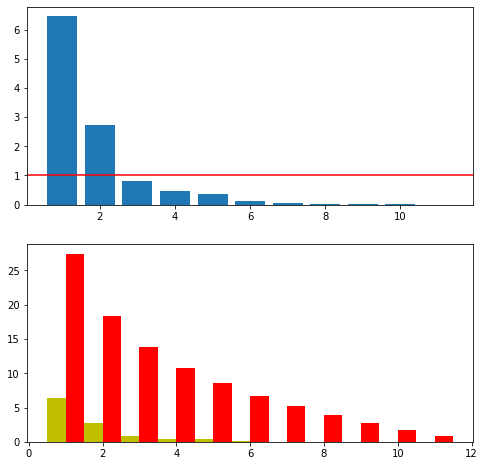

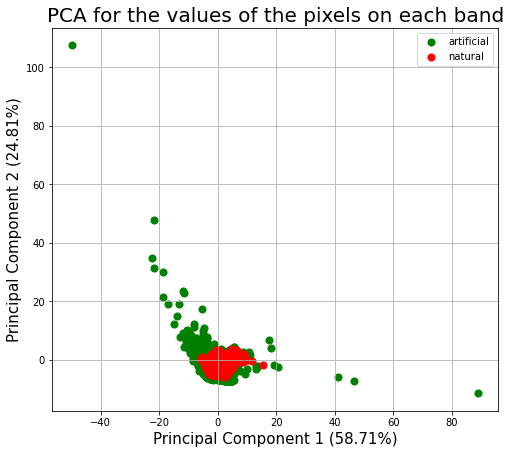

In [36]:
# Test with function

features = BANDS_STR + bands_ratio + ['road_width']
to_describe='road_type'

written_files_pca_pixels=fct_statistics.calculate_pca(pixels_per_band, features, to_describe,
                                                            dirpath_f_tables, dirpath_f_images, 
                                                            file_prefix=f'{balance}PCA_pixels_',
                                                            title_graph='PCA for the values of the pixels on each band')

print(written_files_pca_pixels)

written_files.extend(written_files_pca_pixels)
#### PCA of the road stats

In [ ]:
for band in tqdm(BANDS_STR, desc='Processing bands'):
    roads_stats_filtered_subset=roads_stats_filtered[roads_stats_filtered['band']==band]

    roads_stats_filtered_subset.reset_index(drop=True, inplace=True)
    features = ['min', 'max', 'mean', 'std','median']

    to_describe='road_type'

    written_files_pca_stats=fct_statistics.calculate_pca(roads_stats_filtered_subset, features, to_describe,
                dirpath_f_tables, dirpath_f_images, 
                file_prefix=f'{balance}PCA_stats_band_{band}_',
                title_graph=f'PCA of the statistics of the roads on the {band} band')

    written_files.extend(written_files_pca_stats)


In [ ]:
print(f'Checkout the written files: {written_files}')
